# <center> Customer Lifetime Value (CLV) </center>

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

### Step 1. Understand the dataset

In [50]:
# Load dataset
df = pd.read_csv(r'C:\Users\bpalg\Documents\MS Data\DS for PMs\HW1 clv_transactions.csv')
df.head()

,TransactionID,TransactionDate,CustomerID,Amount
0,1,9/4/2012,1,20.26
1,2,5/15/2012,2,10.87
2,3,5/23/2014,2,2.21
3,4,10/24/2014,2,10.48
4,5,10/13/2012,2,3.94


In [51]:
# 1. Are there any missing values in the dataset?
missing = df.isna().sum(axis=0)
print("Missing values:", missing.sum()>0)
missing

Missing values: False


TransactionID      0
TransactionDate    0
CustomerID         0
Amount             0
dtype: int64

In [52]:
#2. What is the range of dates in the dataset?
df.TransactionDate = pd.to_datetime(df.TransactionDate)
print(f"Date Range: {df.TransactionDate.min()} - {df.TransactionDate.max()}")

Date Range: 2010-01-04 00:00:00 - 2015-12-31 00:00:00


In [53]:
#3. How many unique customers are there in the dataset?
print(f"Unique customers in dataset: {len(df.CustomerID.unique())}")

Unique customers in dataset: 1000


In [54]:
#4. Profile the data to give the standard descriptive statistics for the Amount field. 
# What is the min, max, variance, and standard deviations?

print("Descriptive statistics for Amount:")

df.Amount.describe()


Descriptive statistics for Amount:


count    4186.000000
mean        9.028082
std        38.723909
min        -1.000000
25%         3.310000
50%         6.885000
75%        11.690000
max      2033.000000
Name: Amount, dtype: float64

I see some negative values that may be errors, so I will remove them.

In [55]:
# Removing Negative amounts
num_obs = len(df)
df = df[df.Amount>0]

print(f"{num_obs - len(df)} negative amounts dropped.")

2 negative amounts dropped.


### Step 2. Explore the dataset

1. Are there any outliers?
2. If so how would you treat them?

Text(0.5, 1.0, 'Boxplot for Amount')

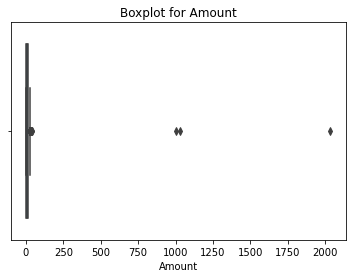

In [56]:
sns.boxplot(df.Amount)
plt.title('Boxplot for Amount')

Based on this plot I would say that there are outliers in the data. I will remove them using the Z score method. 

(cut-off value: Z-scores of +/-3 or further from zero)

In [57]:
# Removing outliers
num_obs = len(df)
df = df[np.abs(stats.zscore(df.Amount)) < 3]

print(f"{num_obs - len(df)} outliers dropped.")

3 outliers dropped.


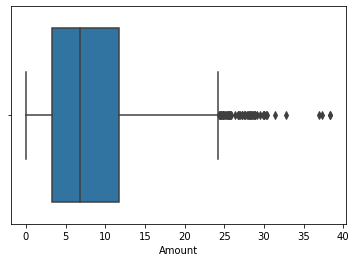

In [58]:
# Plot without outliers
sns.boxplot(df.Amount)

Text(0.5, 1.0, 'Distribution of amounts')

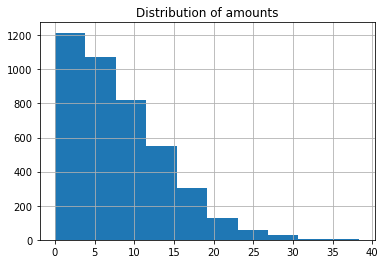

In [59]:
df.Amount.hist()
plt.title('Distribution of amounts')

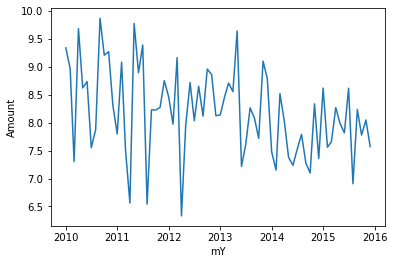

In [60]:
#5. Do transaction amounts in general increase over time (perhaps due to inflation)? (Step 1)
df['mY'] = pd.to_datetime(df.TransactionDate.dt.strftime("%m-%Y"))
amount_over_time = df.groupby("mY").agg({'Amount':'mean'}).reset_index()
amount_over_time

sns.lineplot(x="mY", y="Amount",
             data=amount_over_time)

There isn't an increase of spent amount over time due to inflation.

### Step 3: Determine origin year of customers

In [13]:
# Year of acquisition of customer
df['year'] = df.TransactionDate.dt.year
customer_origin = df.groupby('CustomerID').agg({'year': 'min'})
customer_origin.rename(columns={'year':'origin'}, inplace = True)

In [14]:
# Merge origin with df
df = df.merge(customer_origin, on = 'CustomerID', how ='left')

In [15]:
# Find age
df['age'] = (df['year'] - df['origin'] + 1)*12

Active Customers

In [16]:
active_customers = df.groupby(['origin', 'age']).agg({'CustomerID':'nunique'})
active_customers.rename(columns = {'CustomerID': 'active_customers'}, inplace = True)

New Customers

In [17]:
new_customers = df.groupby(['origin']).agg({'CustomerID':'nunique'})
new_customers.rename(columns = {'CustomerID': 'new_customers'}, inplace = True)

Transactions

In [18]:
transactions = df.groupby(['origin', 'age']).agg({'TransactionID':'nunique'})
transactions.rename(columns = {'TransactionID': 'transactions'}, inplace = True)

### Step 4: Calculate cumulative transaction amounts

Amount

In [19]:
amount = df.groupby(['origin', 'age']).agg({'Amount':'sum'})
amount.rename(columns = {'Amount': 'amount'}, inplace = True)

In [20]:
cumAmount = df.groupby(['origin', 'age']).agg({'Amount' : 'sum'}).groupby(level=0).cumsum()
amount['cum_amount'] = cumAmount

In [64]:
print('Cumulative transaction amounts')
cumAmount.pivot_table(index=["origin"], 
                    columns='age', 
                    values='Amount')

Cumulative transaction amounts


age,12,24,36,48,60,72
origin,,,,,,
2010,2259.67,3614.78,5274.81,6632.37,7930.69,8964.49
2011,2238.46,3757.90,5465.99,6703.11,7862.24,NaN
2012,2181.35,3874.69,5226.86,6501.85,NaN,NaN
2013,2179.85,3609.81,5227.75,NaN,NaN,NaN
2014,1830.85,3262.05,NaN,NaN,NaN,NaN
2015,1912.17,NaN,NaN,NaN,NaN,NaN


### Some extra metrics

Customer Retention

$CR = \frac {ActiveCustomer}{NewCustomers}$

In [21]:
clv = active_customers.reset_index()
clv = clv.merge(new_customers, on = 'origin', how = 'left')
clv['cutomerRetention'] = clv.active_customers/clv.new_customers

Transactions Per Customer

$TransactionsPerCustomer = \frac {Transactions}{ActiveCustomers}$

In [22]:
clv = clv.merge(transactions, on = ['origin', 'age'], how = 'left')
clv['TransactionsPerCustomer'] = clv.transactions/clv.active_customers

Amount per Transaction

$AmountPerTransaction = \frac {Amount}{Transactions}$

In [23]:
clv = clv.merge(amount, on = ['origin', 'age'], how = 'left')
clv['AmountPerTransaction'] = clv.amount/clv.transactions

### Step 5: Calculate New customers

In [66]:
clv.loc[:,['origin', 'age', 'new_customers']].pivot_table(index=["origin"], 
                                                             columns='age',
                                                             values='new_customers')

age,12,24,36,48,60,72
origin,,,,,,
2010,172.0,172.0,172.0,172.0,172.0,172.0
2011,170.0,170.0,170.0,170.0,170.0,NaN
2012,163.0,163.0,163.0,163.0,NaN,NaN
2013,180.0,180.0,180.0,NaN,NaN,NaN
2014,155.0,155.0,NaN,NaN,NaN,NaN
2015,160.0,NaN,NaN,NaN,NaN,NaN


### Step 6: Historic CLV

$HistoricCLV = \frac{CumulativeAmount}{CumulativeNewCustomers}$

In [28]:
clv['historicCLV'] = clv.cum_amount/clv.new_customers

In [25]:
output = clv.loc[:,['origin', 'age', 'cum_amount', 'new_customers', 'historicCLV']]
output = output.pivot_table(index=["origin"], 
                    columns='age', 
                    values='historicCLV')
output

age,12,24,36,48,60,72
origin,,,,,,
2010,13.137616,21.016163,30.667500,38.560291,46.108663,52.119128
2011,13.167412,22.105294,32.152882,39.430059,46.248471,NaN
2012,13.382515,23.771104,32.066626,39.888650,NaN,NaN
2013,12.110278,20.054500,29.043056,NaN,NaN,NaN
2014,11.811935,21.045484,NaN,NaN,NaN,NaN
2015,11.951062,NaN,NaN,NaN,NaN,NaN


Plot historic CLV

Text(0.5, 1.0, 'Historic CLV')

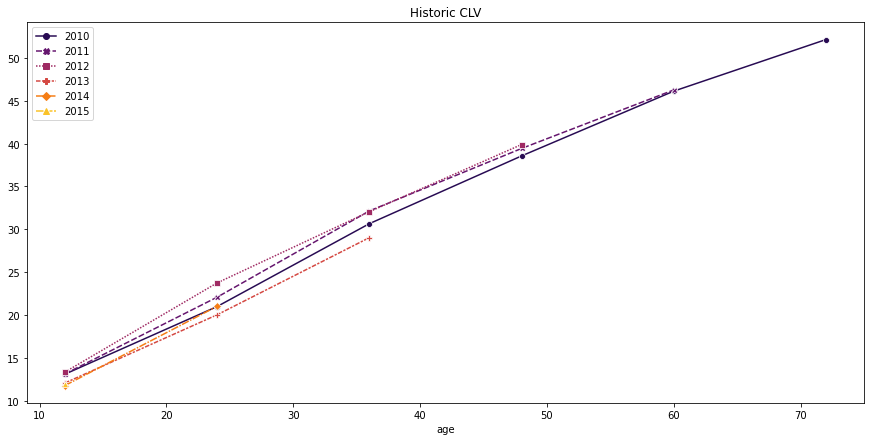

In [26]:
plt.figure(figsize=(15,7))
sns.lineplot(data=output.transpose(), 
             markers=True, palette="inferno")
#plt.plot(output.transpose())
plt.title("Historic CLV")

### Single curve of Historic CLV

In [127]:
# Denominator for weighted CLV
cust_by_age = clv.groupby('age').agg({'new_customers': 'sum'})
cust_by_age.rename(columns = {'new_customers': 'cust_by_age'}, inplace=True)

In [108]:
# Computing weighted CLV
clv = clv.merge(cust_by_age, on = 'age', how = 'left')
weightedCLV = clv.new_customers/clv.cust_by_age*clv.historicCLV
clv['weightedCLV'] = weightedCLV

In [128]:
print("Single curve of Historic CLV")
clv.groupby('age').agg({'weightedCLV':'sum'})

Single curve of Historic CLV


,weightedCLV
age,
12,12.602350
24,21.570512
36,30.942204
48,39.281842
60,46.178158
72,52.119128


Text(0.5, 1.0, 'Historic CLV (single curve)')

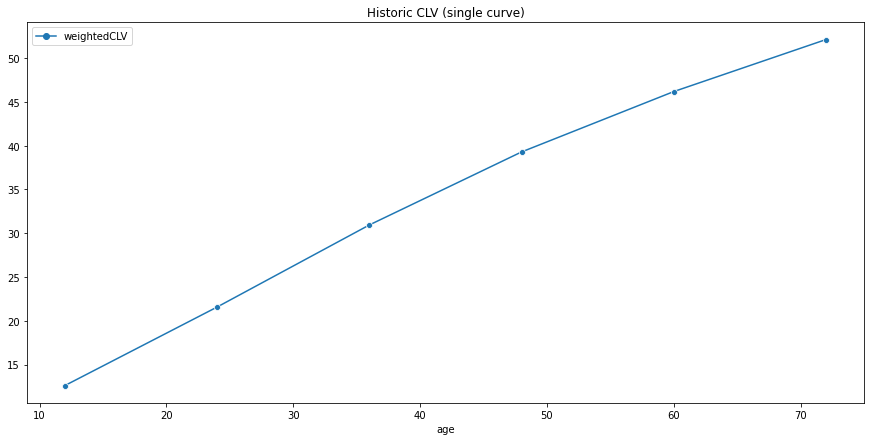

In [126]:
plt.figure(figsize=(15,7))
sns.lineplot(data=clv.groupby('age').agg({'weightedCLV':'sum'}),
            markers=True)
plt.title('Historic CLV (single curve)')

### Step 7: Interpreting Results

Interpret the historic CLV and briefly answer the following question:
- How much have customers acquired in 2011 spent to date? 

**Customers acquired in 2011 have spent $46.25 to date.**
- Do each group of customers exhibit similar or different patterns of spending? What’s the implication for the business?

**On the Historic CLV plot by year, we can see thet differents groups of customers exhibit similar behaviors. It is therefore safe to use the weighted single curve for business decisions.**